In [1]:
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = 'sh-fe080851-d462-4304-9f4d-1b7fd7c7dc95'
config.sh_client_secret = 'XBnxUPfjs1duw9wmexDpoVmhTbY6piHw'
config.sh_base_url = 'https://sh.dataspace.copernicus.eu'
config.sh_token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'

In [2]:
import datetime
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

In [3]:
from typing import Any, Tuple
import cartopy.feature as cfeature

def plot_image(
    image: np.ndarray, factor: float = 1.0, clip_range: Tuple[float, float] = None, extent: Tuple[float, float, float, float] = None, 
    add_features: bool = True, title: str = None, **kwargs: Any
) -> None:
    """Utility function for plotting RGB images with coordinates and optional geographical landmarks."""
    
    # Use Cartopy's PlateCarree projection for geographic data
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
    
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), extent=extent, transform=ccrs.PlateCarree(), **kwargs)
    else:
        ax.imshow(image * factor, extent=extent, transform=ccrs.PlateCarree(), **kwargs)
    
    # Add coastlines or other geographic features if needed
    ax.coastlines(resolution='10m', color='white', linewidth=1)

    # Optionally add more geographical features
    if add_features:
        ax.add_feature(cfeature.BORDERS, edgecolor='yellow', linewidth=1)   # Country borders
        ax.add_feature(cfeature.LAKES, edgecolor='blue', facecolor='none')  # Lakes with no fill
        ax.add_feature(cfeature.RIVERS, edgecolor='blue', linewidth=0.5)    # Rivers

    # Add only coordinate labels, without gridlines
    gl = ax.gridlines(draw_labels=True, linestyle='-', color='none')
    gl.xlines = False
    gl.ylines = False
    gl.top_labels = False
    gl.right_labels = False

    # Add a title if provided
    if title:
        plt.title(title, fontsize=20, pad=20)

In [4]:
hyd_coords_wgs84 = (78.00405826,16.93264351,79.04971836,17.90150706)
resolution=(5500, 3500)
hyd_bbox = BBox(bbox=hyd_coords_wgs84, crs=CRS.WGS84)
hyd_size = bbox_to_dimensions(hyd_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {hyd_size} pixels")

Image shape at (5500, 3500) m resolution: (20, 30) pixels


In [5]:
def generate_image(date_range, output_dir, filename,title, bbox=hyd_bbox, size=hyd_size, config=config):
    evalscript_mean_mosaic = """
    //VERSION=3
    function setup() {
        return {
            input: ["NO2", "dataMask"],
            output: { 
                bands: 4 
            },
            mosaicking: "ORBIT" // To process data from different orbits
        };
    }

    const minVal = 0.0;
    const maxVal = 0.0001;
    const diff = maxVal - minVal;

    const purpleToRed = [
        [minVal, [0, 0, 0.2]],             // Purple
        [minVal + 0.14 * diff, [0, 0, 0.5]], // Blue-Purple
        [minVal + 0.28 * diff, [0, 0, 1]],   // Blue
        [minVal + 0.42 * diff, [0, 1, 1]],   // Cyan
        [minVal + 0.57 * diff, [0, 1, 0]],   // Green
        [minVal + 0.71 * diff, [1, 1, 0]],   // Yellow
        [minVal + 0.85 * diff, [1, 0.5, 0]], // Orange
        [maxVal, [1, 0, 0]]                  // Red
    ];

    const viz = new ColorRampVisualizer(purpleToRed);

    function evaluatePixel(samples) {
        let totalNO2 = 0;
        let validSampleCount = 0;

        // Sum up the NO2 values and count valid samples
        for (let i = 0; i < samples.length; i++) {
            if (samples[i].dataMask === 1) {
                totalNO2 += samples[i].NO2;
                validSampleCount++;
            }
        }

        // Calculate the mean NO2 value
        let meanNO2 = validSampleCount > 0 ? totalNO2 / validSampleCount : 0;

        // If no valid samples, return black color
        if (validSampleCount === 0) {
            return [0, 0, 0, 1]; // Black with full opacity
        }

        // Map values greater than maxVal to red
        if (meanNO2 > maxVal) {
            return [0.3, 0, 0, 1]; // Full Red with full opacity
        }

        // Apply the colormap visualization for values within the range
        let rgba = viz.process(meanNO2);
        rgba.push(1); // Set alpha channel to 1 (fully opaque)

        return rgba;
    }
    """

    request = SentinelHubRequest(
        evalscript=evalscript_mean_mosaic,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL5P.define_from(
                    "s5pl2", service_url=config.sh_base_url
                ),
                time_interval=date_range,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=bbox,
        size=size,
        config=config,
    )

    image = request.get_data()[0]
    plot_image(image, factor=3.5 / 255, extent=(bbox.min_x, bbox.max_x, bbox.min_y, bbox.max_y),add_features=False,title=f"Mean N02 for {title}")

    output_file = os.path.join(output_dir, filename)
    plt.savefig(output_file)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


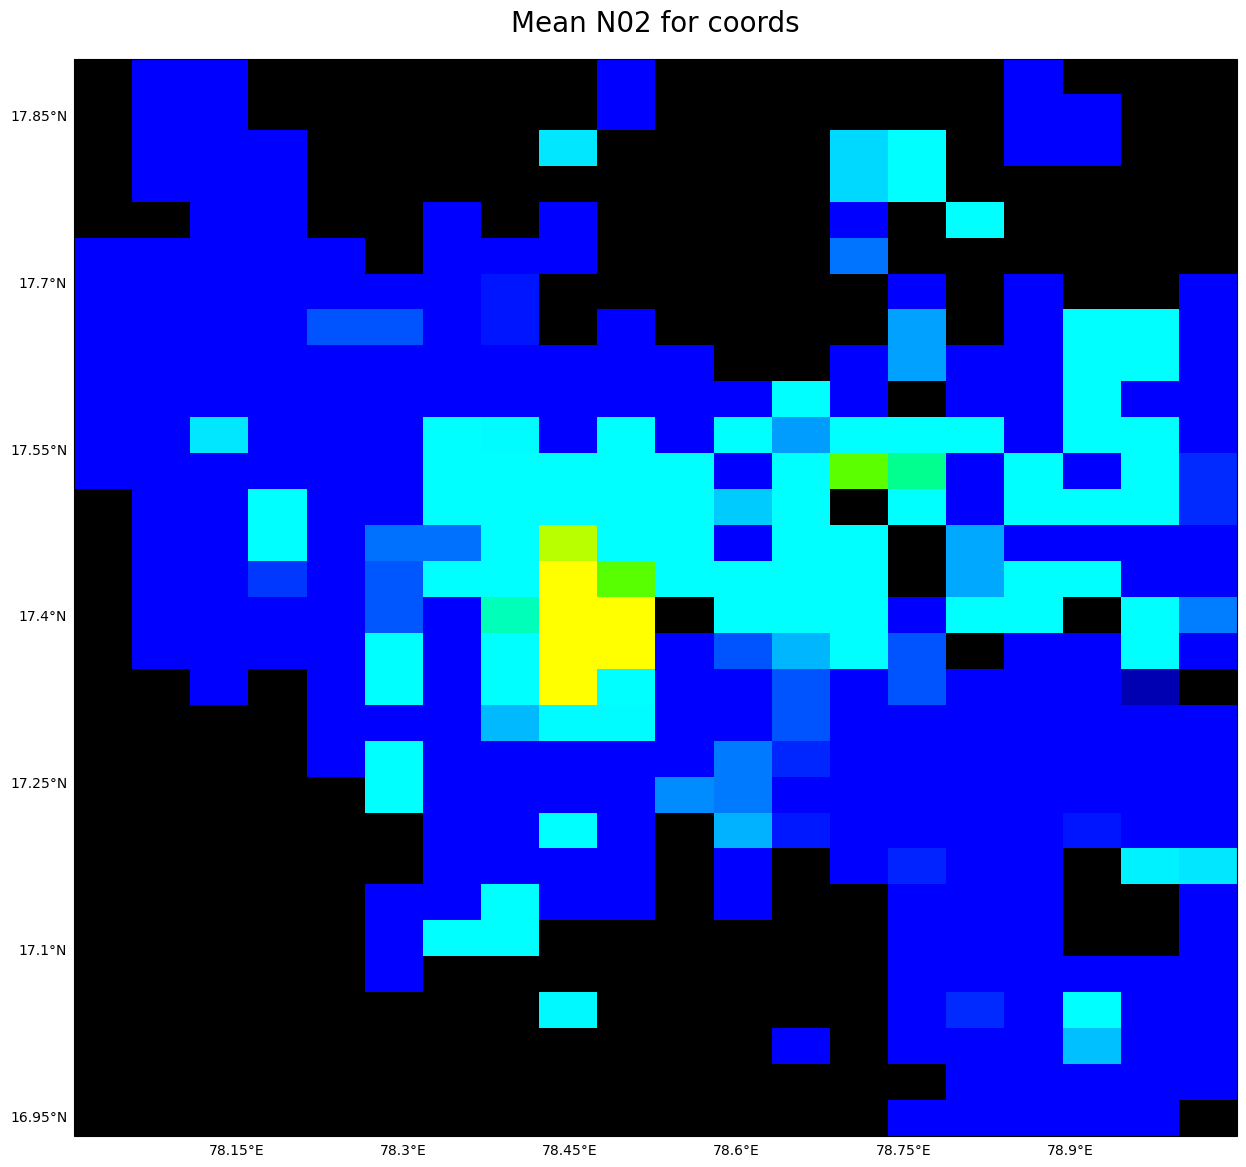

In [6]:
generate_image(("2021-07-16", "2021-07-17"),r"C:\Users\rishi\ml_projects\climate\to_delete","waste2.png",title="coords")

In [7]:
# months = {
#     1: ("January", 31),
#     2: ("February", 28),
#     3: ("March", 31),
#     4: ("April", 30),
#     5: ("May", 31),
#     6: ("June", 30),
#     7: ("July", 31),
#     8: ("August", 31),
#     9: ("September", 30),
#     10: ("October", 31),
#     11: ("November", 30),
#     12: ("December", 31)
# }

# for i in range(1, 13):
#     month_name, end_day = months[i]
#     start=f"2021-{i}-1"
#     end = f"2021-{i}-{end_day}"
#     path = f"image_{i}.png"
#     title = month_name
    
#     generate_image(
#         date_range=(start, end),
#         output_dir=r"C:\Users\rishi\ml_projects\climate\imagesv3",
#         filename=path,
#         title=title
#     )


In [8]:
# for i in range(1,2):
#     start=f"2021-{i}-1"
#     end=f"2021-{i}-28"
#     path=f"image_{i}.png"
#     generate_image((start,end),r"C:\Users\rishi\ml_projects\climate\imagesv2",path,title="January")